In [1]:
import math


import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pylab import rcParams
from scipy.io import loadmat
from sklearn import preprocessing
import statsmodels.api as sm

from numpy import array
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.layers import Flatten
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import math

from tensorflow import set_random_seed

np.random.seed(0)
set_random_seed(0)

Using TensorFlow backend.


In [2]:
# Load the Drive helper and mount
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
df = pd.DataFrame(loadmat('/content/drive/My Drive/Colab Notebooks/Xtrain.mat')['Xtrain'])

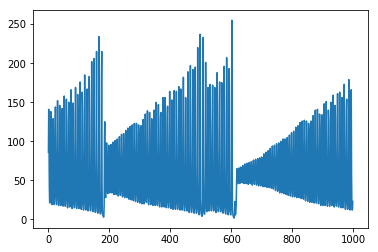

In [4]:
dataset = df.values
dataset = df.astype('float32')
plt.plot(dataset ) # plotting t, a separately 
plt.show()

In [5]:
# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/data.py:334: DataConversionWarning: Data with input dtype float32 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


In [6]:

# split into train and test sets
train_size = int(len(dataset) * 0.8)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
print(len(train), len(test))

800 200


In [0]:

# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-look_back-1):
		a = dataset[i:(i+look_back), 0]
		dataX.append(a)
		dataY.append(dataset[i + look_back, 0])
	return np.array(dataX), np.array(dataY)

In [0]:
# reshape into X=t and Y=t+1
look_back = 50
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

In [9]:
# reshape input to be [samples, time steps, features]

trainX = np.reshape(trainX, (trainX.shape[0],1,trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0],1, testX.shape[1]))

print(trainX.shape) #channels_last

(749, 1, 50)


In [12]:
# create and fit the LSTM network
model = Sequential()
model.add(LSTM(50, activation='relu',return_sequences=True, input_shape=(1, look_back)))
model.add(LSTM(100, activation='relu',input_shape=(1, look_back)))
model.add(Dense(10))
model.add(Activation('relu'))
model.add(Dense(1))


#model.add(LSTM(24, activation='relu',return_sequences=True, input_shape=(1, look_back)))
#model.add(LSTM(16, activation='relu',return_sequences=True))
#model.add(LSTM(8, activation='relu' ))
#model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=100, batch_size=1, verbose=2)

Epoch 1/100
 - 5s - loss: 0.0166
Epoch 2/100
 - 3s - loss: 0.0087
Epoch 3/100
 - 3s - loss: 0.0062
Epoch 4/100
 - 3s - loss: 0.0052
Epoch 5/100
 - 3s - loss: 0.0041
Epoch 6/100
 - 3s - loss: 0.0038
Epoch 7/100
 - 3s - loss: 0.0038
Epoch 8/100
 - 3s - loss: 0.0032
Epoch 9/100
 - 3s - loss: 0.0026
Epoch 10/100
 - 3s - loss: 0.0021
Epoch 11/100
 - 3s - loss: 0.0018
Epoch 12/100
 - 3s - loss: 0.0019
Epoch 13/100
 - 3s - loss: 0.0025
Epoch 14/100
 - 3s - loss: 0.0015
Epoch 15/100
 - 3s - loss: 0.0017
Epoch 16/100
 - 3s - loss: 0.0018
Epoch 17/100
 - 3s - loss: 0.0018
Epoch 18/100
 - 3s - loss: 0.0014
Epoch 19/100
 - 3s - loss: 0.0014
Epoch 20/100
 - 3s - loss: 0.0014
Epoch 21/100
 - 3s - loss: 0.0013
Epoch 22/100
 - 3s - loss: 0.0015
Epoch 23/100
 - 3s - loss: 8.6237e-04
Epoch 24/100
 - 3s - loss: 0.0012
Epoch 25/100
 - 4s - loss: 0.0013
Epoch 26/100
 - 3s - loss: 9.6220e-04
Epoch 27/100
 - 3s - loss: 0.0016
Epoch 28/100
 - 3s - loss: 9.4609e-04
Epoch 29/100
 - 3s - loss: 8.9906e-04
Epoch 3

In [0]:
test_predict = np.empty_like(dataset)
test_predict[:,:] = np.nan



look_back = trainX[len(trainX)-1,:,:]
look_back = look_back[np.newaxis,:,:]
prediction = list()

for i in range(200):
    p = model.predict(look_back)
    prediction.append(p[0])
    p = np.reshape(p, (1,1,1))  # Reshape for appending
    temp = look_back[:,:,1:]  # Cut the first
    look_back = np.append(temp,p,axis=2)

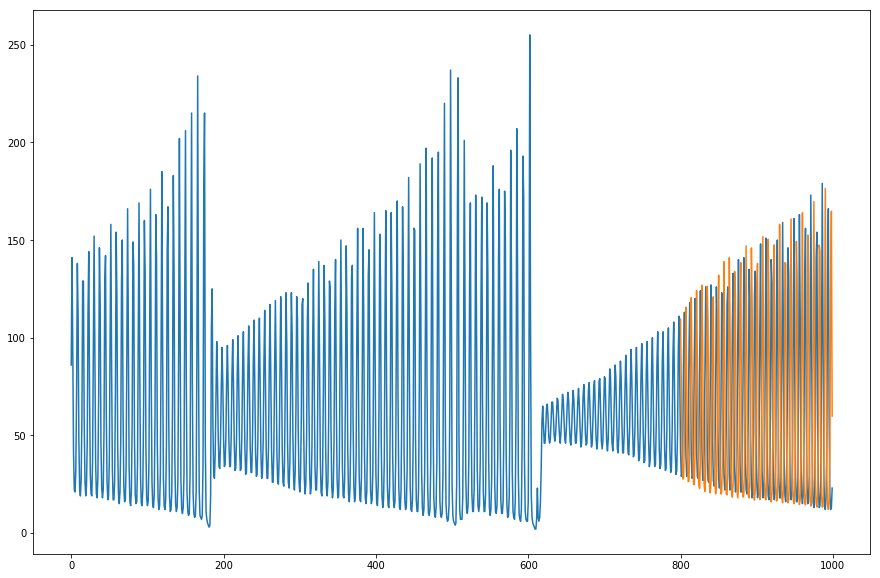

200


In [14]:
import matplotlib.pyplot as plt
from google.colab import files
test_predict[len(dataset)-len(prediction):,:] = prediction

plt.figure(figsize=(15,10))
plt.plot(scaler.inverse_transform(dataset))
plt.plot(scaler.inverse_transform(test_predict))
plt.savefig('test1lstm.png')
plt.show()


files.download('test1lstm.png')
print(len(prediction))

In [1]:
model.summary()

NameError: ignored

In [2]:
# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

NameError: ignored